In [1]:
import sys
from itertools import chain, product
from typing import List, Tuple, Optional, Any, Dict
import pandas as pd
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import PandasTools

sys.path.append('..')
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from rhea.chem.molecule import Molecule
from nnet.models.egnn import EquivariantGNN
from diff.models.diffusion import *
from diff.models.scheduler import *
#from src.preprocessing.chem import molecule_to_Data
from diff.tools import *

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
c:\Users\cabe\Documents\repos\ChemAI\notebooks\..\diff\models\diffusion.py:50: SyntaxWarning: invalid escape sequence '\m'
  """
c:\Users\cabe\Documents\repos\ChemAI\notebooks\..\diff\models\diffusion.py:319: SyntaxWarning: invalid escape sequence '\p'
  """Function to return the loss. This loss represents each term L_{t-1} in the ELBO of diffusion models.


In [2]:
from torch_geometric.datasets import QM9
dataset = QM9(
    root='../data/QM9',
)

c:\Users\cabe\anaconda3\envs\MLChem\Lib\site-packages\torch_geometric\data\dataset.py:239: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
c:\Users\cabe\anaconda3\envs\MLChem\Lib\site-packages\torch_geometric\data\dataset.py:247: UserWarning: The `pre_filter` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-fitering technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


In [3]:
dataset[0].z

tensor([6, 1, 1, 1, 1])

In [4]:
df = pd.read_pickle('../data/QM9/raw/gdb9.pkl')

In [5]:
ATOM_TYPES = ['C', 'O', 'N', 'H', 'F', 'Cl', 'Br', 'I', 'P', 'S']

# Example predefined bond types
BOND_TYPES = [Chem.BondType.SINGLE, Chem.BondType.DOUBLE, Chem.BondType.TRIPLE, Chem.BondType.AROMATIC]

"""However, using discrete values to
model atom and bond types is a more natural way and also
showed better performance (see results in Sec. 4.1)."""


def molecule_to_Data(mol: Molecule, 
                     idx: int = 0,
                     target: torch.Tensor = torch.tensor([0,1], dtype=torch.float32)
                                ) -> Data:
    """
    Converts a molecule into a torch geometric `Data` object with noise scaling schedule.
    
    The structure of the `Data` object is as follows:
    ```
            {
                'x': torch.Tensor,                   # node features (one-hot encoded atom types)
                'edge_index': torch.Tensor,          # edges between atoms derived from covalent bonds (source_n, target_n)
                'edge_attr': torch.Tensor,           # bond features (one-hot encoded bond types)
                'y': torch.Tensor,                   # target
                'pos': torch.Tensor,                 # atomic coordinates
                'idx': torch.Tensor,                 # index of the molecule
                'name': str,                         # molecule name
                'z': torch.Tensor,                   # atomic numbers
                'complete_edge_index': torch.Tensor  # complete graph connectivity
            }
    ```
    
    Args:
        mol (Chem.Mol): The molecule.
        beta (float): Noise scaling schedule parameter.
        target (torch.Tensor, optional): The target. Defaults to torch.tensor([0], dtype=torch.float32).
    
    Returns:
        Data: The molecule as a `Data` object.
    """

    data = dict()
    data['name'] = mol.molecule.GetProp('_Name') if mol.molecule.HasProp('_Name') else "Molecule_{}".format(idx)
    data['smiles'] = Chem.MolToSmiles(mol.molecule)
    coordinates = mol.get_coordinates()
    pos = torch.tensor(coordinates, dtype=torch.float32)
    data['pos'] = pos
    
    x = []                                                                                          
    edge_index = []                                                                                 
    edge_attr = []
    bond_matrix = torch.zeros((len(mol.GetAtoms()), len(mol.GetAtoms()), len(BOND_TYPES)), dtype=torch.float32)
    
    for atom in mol.GetAtoms():

        atom_type = torch.tensor([1 if atom.GetSymbol() == atom_type else 0 for atom_type in ATOM_TYPES], dtype=torch.float32)
        x.append(atom_type)

    for bond in mol.GetBonds():

        bond_type = torch.tensor([1 if bond.GetBondType() == bond_type else 0 for bond_type in BOND_TYPES], dtype=torch.float32)
        bond_matrix[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()] = bond_type
        bond_matrix[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()] = bond_type
        edge_attr.append(bond_type)
        edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    
    data['x'] = torch.stack(x, dim=0)
    data['edge_index'] = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    if len(edge_attr) == 0:
        edge_attr = torch.zeros((data['edge_index'].size(1), len(BOND_TYPES)), dtype=torch.float32)
    data['edge_attr'] = torch.stack(edge_attr, dim=0)
    # add atomic numbers
    data['z'] = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.long)
    data['idx'] = torch.tensor([idx], dtype=torch.long)

    data['complete_edge_index'] = torch.tensor([[i, j] for i in range(data['x'].size(0)) \
        for j in range(data['x'].size(0)) if i != j], dtype=torch.long).t().contiguous()

    data['y'] = target
    data['bond_matrix'] = bond_matrix

    return Data(**data)

In [6]:

m = df.ROMol.iloc[50]
#m = Chem.AddHs(m, addCoords=True) # Hs are not considered because they can be easily added later
m = Molecule(m)
d = molecule_to_Data(m, 0)
print(d)

Data(x=[5, 10], edge_index=[2, 5], edge_attr=[5, 4], y=[2], pos=[5, 3], name='Molecule_0', smiles='C1=CCOC1', z=[5], idx=[1], complete_edge_index=[2, 20], bond_matrix=[5, 5, 4])


In [7]:
d.z

tensor([6, 8, 6, 6, 6])

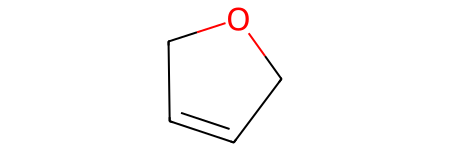

In [8]:
m

In [9]:
d

Data(x=[5, 10], edge_index=[2, 5], edge_attr=[5, 4], y=[2], pos=[5, 3], name='Molecule_0', smiles='C1=CCOC1', z=[5], idx=[1], complete_edge_index=[2, 20], bond_matrix=[5, 5, 4])

In [10]:
# dataset = []
# # Create a Dataset
# for idx, i in enumerate(tqdm(range(len(df)))):#len(df)
#     m = df.ROMol.iloc[i]
#    #m = Chem.AddHs(m, addCoords=True) # Hs are not considered because they can be easily added later
#     m = Molecule(m)
#     d = molecule_to_Data(m, idx)
#     dataset.append(d)

# Forward Process

- Adds noise to the data based on a pre-defined noise schedule.
- t denote variables at time step $t(t = 0,1,...T)$
- $M^t$ is sampled from the distribution $q(M^t | M^{t-1})$ only conditioned on $M^{t-1}$.
- For atom types and bond types we represent them using categorical distributions.
    - $q(r^{t}_i | r^{t-1}_i) := \mathcal{N}(r^{t}_i | \sqrt{1-\beta^{t} r^{t-1}_i}, \beta^{t}\mathbb{I})$
    - $q(a^{t}_i | a^{t-1}_i) := \mathcal{C}(a^{t}_i | (1-\beta^{t}) a^{t-1}_i, \beta^{t}\mathbb{1}_k)$ 
    - $q(b^{t}_{ij} | b^{t-1}_{ij}) := \mathcal{C}(b^{t}_{ij} | (1-\beta^{t}) b^{t-1}_{ij}, \beta^{t}\mathbb{1}_k)$
- $\beta^t \in [0,1]$ (noise scaling schedule).
- $\mathbb{I}^{3x3}$ is the identity matrix.
- $\mathbb{1}_k$ represents a one-hot vector with one at the kth position and all the others zeros.

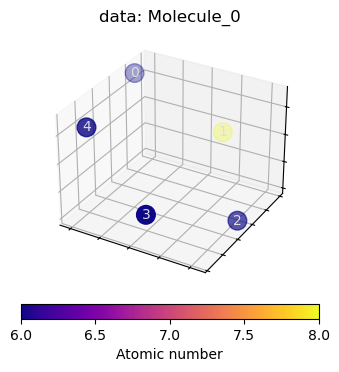

In [11]:
fig = plt.figure()
ax = plot_model_input(d, fig, 111)
_ = ax.set_title(f"data: {d['name']}")

In [12]:
# T = 1000  # Total number of time steps

# # Assuming `d` is your molecule data from previous code
# for t in range(T):
#     noisy_data = forward_diffusion(d, t, T)
#     if t % 50 == 0:
#         fig = plt.figure()
#         ax = plot_model_input(noisy_data, fig, 111)
#         _ = ax.set_title(f"Noisy data at time step {t}")
#         plt.show()

In [13]:
# # compare the original molecule with the noisy molecule
# fig = plt.figure(figsize=(10, 5))
# ax1 = plot_model_input(d, fig, 121)
# ax1.set_title("Original molecule")
# ax2 = plot_model_input(noisy_data, fig, 122)
# ax2.set_title("Noisy molecule")
# plt.show()


In [14]:
def plot_position(
        pos: torch.Tensor, 
        atomic_numbers: torch.Tensor,
        fig: mpl.figure.Figure,
        ax_pos: int = 111) -> mpl.axis.Axis:
    """
    Plots 3D point cloud model input represented by a torch geometric
    `Data` object. Use atomic numbers as colors.

    Parameters
    ----------
    data : Data
        The 3D point cloud. Must have atomic numbers `z` and 2D coordinates `pos`
        properties that are not `None`.
    fig: mpl.figure.Figure
        The maptlotlib figure to plot on.
    ax_pos:
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`).

    Returns
    -------
    mpl.axis.Axis
        The newly created axis object.
    """
    color, pos = atomic_numbers, pos
    color = color.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(fig, ax_pos, color, pos, cbar_label="Atomic number")


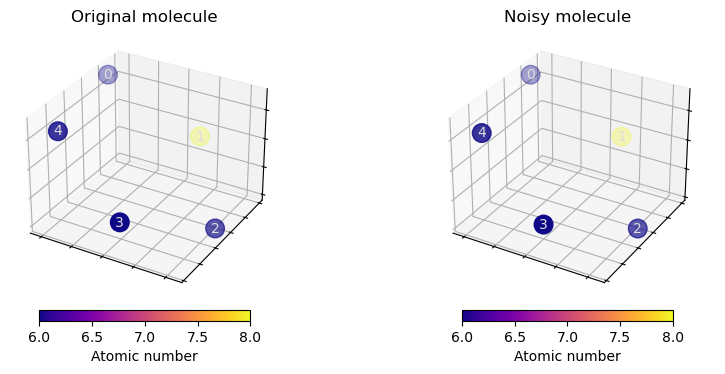

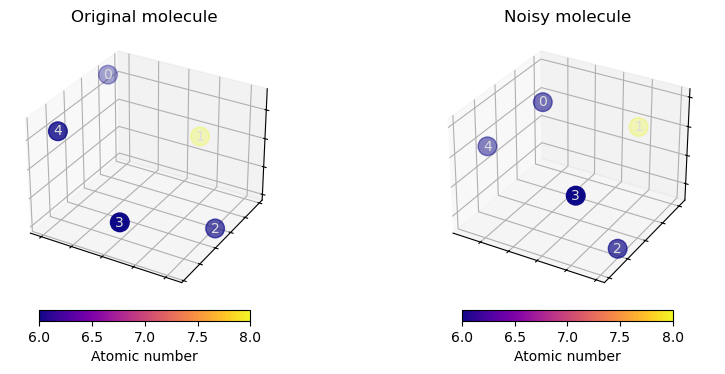

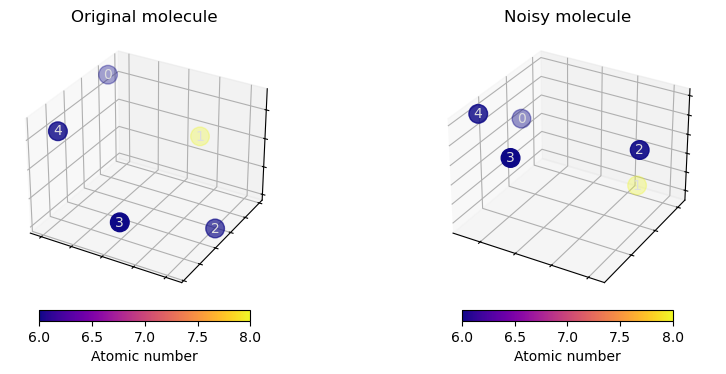

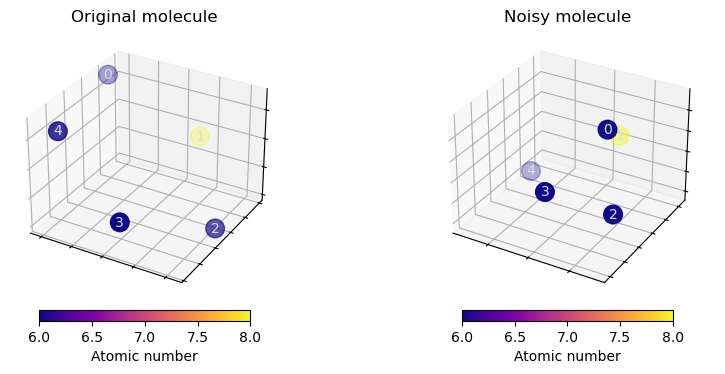

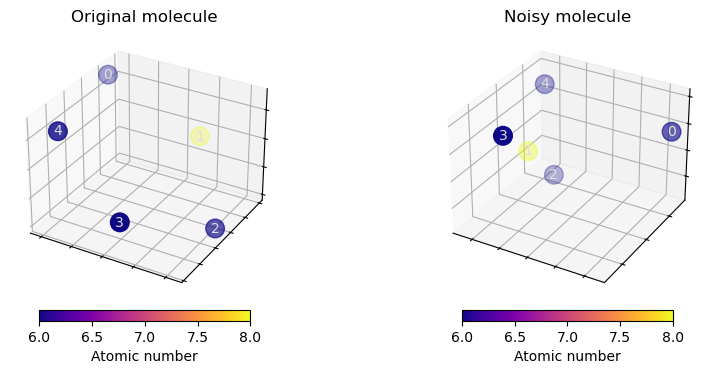

In [15]:
mean_atom_pos = []

T = 1000  # Total number of time steps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
diffuser = Diffusion(timesteps=T).to(device)
atomic_numbers = d.z.to(device)
# Assuming `d` is your molecule data from previous code
for t in range(T):

    noisy_data = diffuser.qrt(d.pos.to(device), t)
    # plot the noisy point cloud every 200 time steps
    if t % 200 == 0:
        noisy_data = noisy_data.to('cpu')
        d = d.to('cpu')
        mean_atom_pos.append(noisy_data.mean(dim=0).detach().numpy())
        # compare the original molecule with the noisy molecule
        fig = plt.figure(figsize=(10, 5))
        ax1 = plot_model_input(d, fig, 121)
        ax1.set_title("Original molecule")
        ax2 = plot_position(noisy_data, atomic_numbers, fig, 122)
        ax2.set_title("Noisy molecule")
        plt.show()
        
    # # compare atom types of the original molecule with the noisy molecule
    # if t % 200 == 0:
    #     print(d.x, noisy_data.x)

In [16]:
# # plot the mean atom positions over time as a 3D point cloud
# mean_atom_pos = np.array(mean_atom_pos)
# fig = plt.figure()
# ax = plot_point_cloud_3d(fig, 111, mean_atom_pos.T, cbar_label="Mean atom position")
# _ = ax.set_title("Mean atom position over time")


In [17]:
dataset = []
# Create a Dataset
for idx, i in enumerate(tqdm(range(100))):#len(df)
    m = df.ROMol.iloc[i]
   #m = Chem.AddHs(m, addCoords=True) # Hs are not considered because they can be easily added later
    m = Molecule(m)
    d = molecule_to_Data(m, idx)
    dataset.append(d)

100%|██████████| 100/100 [00:00<00:00, 2594.14it/s]


In [18]:
# # diffusion to all data
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# noisy_dataset = []
# for d in tqdm(dataset):
#     d = d.to(device)
#     diffuser = Diffusion(timesteps=T).to(device)

#     for t in range(T):
#         noisy_data = diffuser.forward(d, t)
#     noisy_dataset.append(noisy_data)

In [19]:
ATOM_TYPES

['C', 'O', 'N', 'H', 'F', 'Cl', 'Br', 'I', 'P', 'S']

# Categorical diffussion

In [24]:
from diff.models.diffusion import Multinomial_diffussion

T = 1000  # Total number of time steps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

atomic_numbers = d.z.to(device)
# Assuming `d` is your molecule data from previous code
atom_diffuser = Multinomial_diffussion(
        categorical_feature_names=ATOM_TYPES,
        # atoms to integers List[int]
        categorical_levels=[i for i in range(len(ATOM_TYPES))],
        timesteps=T,
        device=device
        )

log_x_0 = torch.zeros((len(ATOM_TYPES),), dtype=torch.float32).to(device)

for t in range(T):
 #.to(device)
    # atoms
    atoms = d.x.to(device)
    log_x_t = atom_diffuser.forward_sample(log_x_0, t)
    print(log_x_t)

    # bonds 

10


c:\Users\cabe\Documents\repos\ChemAI\notebooks\..\diff\models\diffusion.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("betas", to_torch(betas).to(self.device))
c:\Users\cabe\Documents\repos\ChemAI\notebooks\..\diff\models\diffusion.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("alphas", to_torch(alphas).to(self.device))
c:\Users\cabe\Documents\repos\ChemAI\notebooks\..\diff\models\diffusion.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("alpha_bar", to_t

RuntimeError: The size of tensor a (10) must match the size of tensor b (45) at non-singleton dimension 0

In [ ]:
def train_loss(x: torch.Tensor):
    # uniform t
    t = torch.randint(0, T, (1,)).item()
    # normal(0, 1) noise
    eps = torch.randn_like(x)
    x_crpt = np.sqrt(gamma(t)) * x_bits + np.sqrt(1 - gamma(t)) * eps

    #predict and compute loss
    x_pred = model(x_crpt, t)
    loss = F.mse_loss(x_pred, x)
    return loss